# デュアル構造を持つネットワークの検索用ノートブック(2019/11/26作成)

- リファクタリングを兼ねてもう一度綺麗に実装してみる

## 初期設定とライブラリのimport

In [1]:
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os

In [2]:
BASE_PATH = './dataset/crop_img/img/DRESSES/Dress/'
category = 'Dress'

## エラー対応
- ~~**RTX系のGPU**で回すとUnknownErrorを吐くため以下コードにより回避~~
- なぜかこちらのコードがエラーを吐くようになった(GPUマシンのアップデート後)
- GPU番号を指定していないことが原因らしい

In [3]:
# import tensorflow as tf
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# tf.keras.backend.set_session(tf.Session(config=config))

- GPUを指定する

In [4]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
        visible_device_list="0", # specify GPU number
        allow_growth=True
    )
)
set_session(tf.Session(config=config))

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## モデルの読み込み

In [5]:
from keras.models import load_model

In [8]:
vec_length = 300
model_epoch = 99
ALPHA = 0.1
BETA = 0.05 #improved triplet lossの場合

In [9]:
# model_dir = "./model/T_Shirt/improved_tripletloss/a{}b{}".format(ALPHA,BETA)
model_dir = "./model/{}/Dual_improved/a{}b{}".format(category,ALPHA,BETA)

In [10]:
con_embNet = load_model(model_dir+'/{}/con_e{}.h5'.format(vec_length,model_epoch), compile=False)
shop_embNet = load_model(model_dir+'/{}/shop_e{}.h5'.format(vec_length,model_epoch), compile=False)

Instructions for updating:
Colocations handled automatically by placer.


In [11]:
# con_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/con_e99.h5', compile=False)
# shop_embNet = load_model('./model/T_Shirt/tripletloss/a0.1/512/shop_e99.h5', compile=False)

## Testデータの読み込み
- 学習前にtrain/test分割してpickle保存したファイルからtestに用いる商品idをロードする
- 一つの商品idに対して一つの[Street画像,Shop画像]ペアとする。詳しくは`./datagen.py`参照

In [12]:
f = open("./pickle/{}/test_ids.pickle".format(category),"rb")
test_ids = pickle.load(f) #test用の商品id

- 自作モジュールのインポート

In [13]:
from modules import datagen

In [14]:
test_pairs = datagen.get_test_pairs(test_ids,BASE_PATH,seed_num=0)

100%|██████████| 879/879 [00:00<00:00, 2476.06it/s]


- 中身は`[商品id,[Street画像のパス,Shop画像のパス]]`

In [15]:
test_pairs[0]

[14966,
 ['./dataset/crop_img/img/DRESSES/Dress/id_00014966/comsumer_01.jpg',
  './dataset/crop_img/img/DRESSES/Dress/id_00014966/shop_01.jpg']]

- 作成したtest_pairsをpickleで保存する

In [16]:
f = open('./pickle/{}/test_pairs.pickle'.format(category), 'wb')
pickle.dump(test_pairs, f)

## 検索対象の画像群(gallery)の作成

- galleryリストに対して、test_pairsから[商品id, Shop画像パス]のリスト作成してappendする

In [17]:
gallery = []
for tp in test_pairs:
    gallery.append([tp[0],tp[1][1]])

In [18]:
print(gallery[0])
print('gallery length = {}'.format(len(gallery)))

[14966, './dataset/crop_img/img/DRESSES/Dress/id_00014966/shop_01.jpg']
gallery length = 879


## galleryを特徴空間ベクトルに埋め込む

- 埋め込み次元はvec_lengthとして定義済み
- 最初に次元数分のnumpy配列を用意しておき、書き換える。
- ans_idsは正解となる商品idのリスト(test_pairsをforで回してtp[0]のリストを作るのと同義)

In [19]:
emb_vecs = np.zeros((len(gallery),vec_length))
ans_ids = np.zeros(len(gallery))
print(emb_vecs.shape)
print(ans_ids.shape)

(879, 300)
(879,)


- shop_embNet.predict()で推論を行う。デュアル構造のため、入力として同じimgを二つ与える
- 入力時の形を合わせるためexpand_dimsの処理が必要(試行錯誤の結果なので詳細は忘れた)

In [20]:
for i,g in enumerate(tqdm(gallery)):
    img =np.array(Image.open(g[1]).resize((128,128)).convert('RGB'))/255.
    ans_ids[i] = g[0]
    emb_vecs[i] = shop_embNet.predict([np.expand_dims(img,axis=0),np.expand_dims(img,axis=0)])[0] # need [0] because of expanding dimension -> [[]]

100%|██████████| 879/879 [00:08<00:00, 108.98it/s]


- **重要!!** 後に結果を解釈するために埋め込んだベクトルをpickleに保存

In [21]:
f = open(model_dir+'/{}/gallery{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(emb_vecs,f)

In [22]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/gallery{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(emb_vecs,f)

- ユークリッド距離計算用関数

In [23]:
def euclid_dist(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

- Queryの用意

In [24]:
query_ids = np.zeros(len(test_pairs))
print(query_ids.shape)

(879,)


In [25]:
for i,tp in enumerate(test_pairs):
    query_ids[i] = tp[0]
query_ids[:5]

array([14966., 26242., 18284.,  9731., 26320.])

## 距離計算とランキングの算出
- topN_id_listはそれぞれのqueryに対し上位N個までの商品idのランキングがリストとして算出される。
- [[商品Aのランキング],[商品Bのランキング],...[商品Xのランキング],...]のような形

In [26]:
N = 50

- Street画像(Query)の**埋め込みと距離計算**
- argsort()は昇順に並べたときのindexの配列を返す
- similaritiesとans_idsの同じインデックスは同じ商品idを指している
- つまり、対応するans_idsをidxsリストを与えることで切り出す

In [27]:
topN_id_list = []
query_emb_vecs = np.zeros((len(gallery),vec_length))
for i,tp in enumerate(tqdm(test_pairs)):
    img = np.array(Image.open(tp[1][0]).resize((128,128)).convert('RGB'))/255.
    query_emb = con_embNet.predict([np.expand_dims(img.astype(np.float32),axis=0),np.expand_dims(img.astype(np.float32),axis=0)])[0]
    query_emb_vecs[i] = query_emb
    # calculation
    similarities = np.zeros(len(gallery))
    for i,emb_vec in enumerate(emb_vecs):
        similarities[i] = euclid_dist(query_emb,emb_vec)
    # argsort
    idxs = similarities.argsort()
    topN_id_list.append(ans_ids[idxs[:N]])  

100%|██████████| 879/879 [00:12<00:00, 70.85it/s]


In [28]:
topN_id_list[0]

array([31080., 28328., 25985., 21513.,  8510., 12619., 13499., 17926.,
       25427., 20119., 25299., 20223., 16467., 22224., 10010., 22298.,
       29333., 12350., 12540., 11918., 33317., 22599., 21441., 32217.,
       15019., 30592., 18271., 29531.,   609.,  3203.,  6912., 24018.,
       11174., 24327., 28661., 18735., 20601., 12702., 12102., 16552.,
       26871., 19544., 20219.,  9072.,  9174., 24413.,  9061., 29873.,
        9752., 22384.])

- 検索結果画像を表示するためにtopN_id_listを保存

In [29]:
f = open(model_dir+'/{}/topN_id_list{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(topN_id_list,f)

In [30]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/topN_id_list{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(topN_id_list,f)

In [31]:
len(emb_vecs)

879

- **重要!!** のちに結果を解釈(**ヒストグラム描画**など)するためquery_embをpickle保存

In [32]:
f = open(model_dir+'/{}/query{}.txt'.format(vec_length,model_epoch),'wb')
pickle.dump(query_emb_vecs,f)

In [33]:
# f = open('./model/T_Shirt/tripletloss/a{}/{}/query{}.txt'.format(ALPHA,vec_length,model_epoch),'wb')
# pickle.dump(query_emb_vecs,f)

## Top-Kの計算とグラフの描画

- ans_idsとtopN_id_listをzipで同時に回す
- あるans_idを見たとき、対応するインデックスのtopN_idの中に同じidが入っていればcntを+1

In [34]:
def calc_topk_vals(k_values,ans_ids,topN_id_list):
    topk_vals = []
    for k in k_values:
        cnt = 0
        for i,(ans_id,topN_id) in enumerate(zip(ans_ids,topN_id_list)):
            if ans_id in topN_id[:k]:
                cnt+=1
        topk_vals.append(cnt/len(ans_ids))
    return topk_vals

In [35]:
x = list(range(1,51))
topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)

In [36]:
f = open(model_dir+'/{}/topK_vals.txt'.format(vec_length), 'wb')
pickle.dump(topk_vals, f)

In [37]:
# f = open('./model/T_Shirt/topK/TripletLoss_{}.txt'.format(vec_length), 'wb')
# pickle.dump(topk_vals, f)

In [38]:
topk_vals

[0.04664391353811149,
 0.07736063708759955,
 0.1012514220705347,
 0.1149032992036405,
 0.13765642775881684,
 0.15244596131968147,
 0.16496018202502843,
 0.17633674630261661,
 0.18430034129692832,
 0.19340159271899887,
 0.20477815699658702,
 0.21843003412969283,
 0.2229806598407281,
 0.23208191126279865,
 0.23890784982935154,
 0.24573378839590443,
 0.2593856655290102,
 0.267349260523322,
 0.27303754266211605,
 0.27986348122866894,
 0.2901023890784983,
 0.29579067121729236,
 0.29692832764505117,
 0.3003412969283277,
 0.30489192263936293,
 0.310580204778157,
 0.3174061433447099,
 0.32195676905574516,
 0.3310580204778157,
 0.33560864618885095,
 0.3390216154721274,
 0.3447098976109215,
 0.34812286689419797,
 0.35381114903299204,
 0.3572241183162685,
 0.36291240045506257,
 0.36746302616609783,
 0.36860068259385664,
 0.37770193401592717,
 0.3799772468714448,
 0.38680318543799774,
 0.3890784982935154,
 0.391353811149033,
 0.39362912400455063,
 0.3970420932878271,
 0.40273037542662116,
 0.40500

- グラフの描画

/home/pip/koki_ishizuka/.conda/envs/py35-zukapy/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


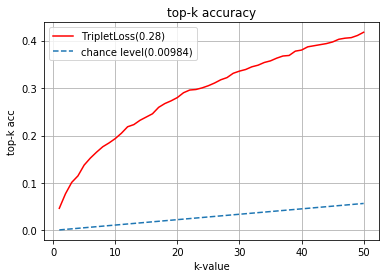

In [39]:
x = list(range(1,51))
chancelv=np.array(x)/len(test_pairs)

topk_vals = calc_topk_vals(x,ans_ids,topN_id_list)
plt.plot(x,topk_vals,c='r',label='TripletLoss({})'.format(round(topk_vals[19],3)))
# plt.plot(x,topk_vals,c='r',marker='o',label='improvedTripletLoss({})'.format(round(topk_vals[4],3)))
plt.plot(x,chancelv,linestyle='dashed',label='chance level(0.00984)')

# graph settings
plt.legend(loc='best')#,bbox_to_anchor=(1, 0.2))
plt.grid('True')
plt.title("top-k accuracy")
plt.xlabel("k-value")
plt.ylabel("top-k acc")
plt.show()

# 結果と考察

- vec_lengthは結果に対してかなり影響がある

Top20 accuracy

| Dimension | Single | Dual(Triplet Loss) | Dual(improved Triplet Loss) |
|:-:|:-:|:-:|:-:|
|100|  0.141  | - | -|
|200|-  |0.175  | - |
|300|-  | 0.126 | 0.201 |
|512|0.2  |0.156  |0.108  |

alpha=0.5にしたら0.157に変化した
原因はhistgram要確認
